# Change detection demos on ONERA dataset

[ps] possible next steps: https://github.com/isaaccorley/torchrs#onera-satellite-change-detection-oscd

In [ ]:
#### [CONFIG] ####

# model =========================================

#BACKBONE = 'resnet34'
BACKBONE = 'resnet18'

# model training ==================================

epochs = 30

train_augmentations = True # random flips and rotations, doubles the training dataset
second_round_of_slower_lr_training = True # might not help actually...
slower_epochs = 30

# dataset =========================================

## note: filter and overlap applies only to the training set

tile_size = 64
overlap = 32

filter_enough_change = True
#change_pix_percent = 0.0 # has at least some change
change_pix_percent = 0.03 # has at least 3% change (1044 samples)

# Class re-weighing?
#  referential solution uses: weights = [ FP_MODIFIER * 2 * true_pix / n_pix, 2 * (n_pix - true_pix) / n_pix] # FP_MODIFIER=10
weights = [0.4595, 1.9540] # roughly 1 : 4.2

# channels ================================================
LOADING_METHOD = 'rgb_from_pngs'
#LOADING_METHOD = 'channels_from_tifs'

custom_weights_file = "imagenet" # < Only 3 channel ~ RGB can have this!
mode = 'rgb' # 3 channels


#custom_weights_file = None     ### <<< FROM SCRATCH! (maybe quite hard...)
#mode = 'highres' # 10 channels
#mode = 'all' # 13 channels


####=========

# Not possible to display with these anymore ...
NORMALISE_IMGS=True # should be

# ??? maybe band by band normalization ... (images in the pairs folder may be already processed in another way?)
# => get the performance with the png data to the one loaded from the tifs (what is the difference?)


### Faster:
#train_augmentations = False
#second_round_of_slower_lr_training = False
#epochs = 10

**To Do:**


*   Try properly loaded RGB with imagenet / or 10 channels with from scratch training
*   eval on full loaded image (not tiles) (does it work?) then the test score is more comparable
* encoder may be smaller (resnet18) maybe will need tweaks with the model params and tile size
* try tiles as large as 256x256!


In [ ]:
!pip install -q gdown # for downloading from gdrive

%tensorflow_version 1.x
!pip install -q segmentation-models==0.2.0
!pip install -q keras==2.2.4
# wierdly still installs Successfully installed keras-2.7.0 => needs to be called again later ...
!pip install -q h5py==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 45 kB 725 kB/s 
     |████████████████████████████████| 76 kB 2.6 MB/s 
     |████████████████████████████████| 312 kB 5.1 MB/s 
     |████████████████████████████████| 2.9 MB 4.1 MB/s 


In [ ]:
!pip install Keras==2.2.4 -q

In [ ]:
!pip install -q albumentations==0.2.0

     |████████████████████████████████| 60 kB 2.8 MB/s 
     |████████████████████████████████| 631 kB 10.1 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import sklearn.metrics
# all ch loading:
import shutil
from glob import glob
from skimage import io

from tqdm import tqdm
from pprint import pprint

# 0 down

In [ ]:
!mkdir OSCD
%cd OSCD

/content/OSCD


In [ ]:
# Data downloading snippet by https://www.kaggle.com/ktncktnc/change-detection-training/notebook
import gdown

%cd /content/OSCD

# Uploaded to gdrive, but can also be downloaded from https://ieee-dataport.org/open-access/oscd-onera-satellite-change-detection
image_url = 'http://drive.google.com/uc?id=1us6Nr6KKRsqtx9dUVtYnRbJTKIwZIsdV'
train_lb_url = 'http://drive.google.com/uc?id=19bluw98KNjneqjNFXdxWqGYrYEtghRYF'
test_lb_url = 'http://drive.google.com/uc?id=1bPYTUiDL9--ejwK2Ebr6XtpgVHdiVcrZ'

image_output = "OSCD-image.zip"
train_output = "OSCD - Train Labels.zip"
test_output = "OSCD - Test Labels.zip"

gdown.download(train_lb_url, train_output, quiet=False)
gdown.download(test_lb_url, test_output, quiet=False)
gdown.download(image_url, image_output, quiet=False)

/content/OSCD


Downloading...
From: http://drive.google.com/uc?id=19bluw98KNjneqjNFXdxWqGYrYEtghRYF
To: /content/OSCD/OSCD - Train Labels.zip
100%|██████████| 138k/138k [00:00<00:00, 42.3MB/s]
Downloading...
From: http://drive.google.com/uc?id=1bPYTUiDL9--ejwK2Ebr6XtpgVHdiVcrZ
To: /content/OSCD/OSCD - Test Labels.zip
100%|██████████| 83.6k/83.6k [00:00<00:00, 22.4MB/s]
Downloading...
From: http://drive.google.com/uc?id=1us6Nr6KKRsqtx9dUVtYnRbJTKIwZIsdV
To: /content/OSCD/OSCD-image.zip
100%|██████████| 513M/513M [00:04<00:00, 113MB/s]


'OSCD-image.zip'

In [ ]:
!unzip -q \*.zip
!rm *.zip
%cd /content


3 archives were successfully processed.
/content


In [ ]:
img_dir = "/content/OSCD/Onera Satellite Change Detection dataset - Images"
train_dir = "/content/OSCD/Onera Satellite Change Detection dataset - Train Labels"
test_dir = "/content/OSCD/Onera Satellite Change Detection dataset - Test Labels"

# 1b load data (rgb from png / all ch from tifs)

In [ ]:
# slightly different folder struct
def copy_dir_to(source, des):
  listdirs = glob(os.path.join(source, "*/"))
  for dir in listdirs:
    dir_name = dir[dir[:-1].rfind("/")+1:-1]
    shutil.copytree(src = os.path.join(dir, "cm"), dst = os.path.join(des, dir_name, "cm"))

copy_dir_to(train_dir, img_dir)
copy_dir_to(test_dir, img_dir)

In [ ]:
import random
from scipy.ndimage import zoom
from math import floor, ceil, sqrt, exp


def adjust_shape(I, s):
    """Adjust shape of grayscale image I to s."""
    
    # crop if necesary
    I = I[:s[0],:s[1]]
    si = I.shape
    
    # pad if necessary 
    p0 = max(0,s[0] - si[0])
    p1 = max(0,s[1] - si[1])
    
    return np.pad(I,((0,p0),(0,p1)),'edge')
    

def read_sentinel_img(path, NORMALISE_IMGS):
    """Read cropped Sentinel-2 image: RGB bands."""
    im_name = os.listdir(path)[0][:-7]
    r = io.imread(path + im_name + "B04.tif")
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    
    I = np.stack((r,g,b),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I


def read_sentinel_img_leq20(path, NORMALISE_IMGS):
    """Read cropped Sentinel-2 image: bands with resolution less than or equals to 20m."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I

def read_sentinel_img_leq60(path, NORMALISE_IMGS):
    """Read cropped Sentinel-2 image: all bands."""
    im_name = os.listdir(path)[0][:-7]
    
    r = io.imread(path + im_name + "B04.tif")
    s = r.shape
    g = io.imread(path + im_name + "B03.tif")
    b = io.imread(path + im_name + "B02.tif")
    nir = io.imread(path + im_name + "B08.tif")
    
    ir1 = adjust_shape(zoom(io.imread(path + im_name + "B05.tif"),2),s)
    ir2 = adjust_shape(zoom(io.imread(path + im_name + "B06.tif"),2),s)
    ir3 = adjust_shape(zoom(io.imread(path + im_name + "B07.tif"),2),s)
    nir2 = adjust_shape(zoom(io.imread(path + im_name + "B8A.tif"),2),s)
    swir2 = adjust_shape(zoom(io.imread(path + im_name + "B11.tif"),2),s)
    swir3 = adjust_shape(zoom(io.imread(path + im_name + "B12.tif"),2),s)
    
    uv = adjust_shape(zoom(io.imread(path + im_name + "B01.tif"),6),s)
    wv = adjust_shape(zoom(io.imread(path + im_name + "B09.tif"),6),s)
    swirc = adjust_shape(zoom(io.imread(path + im_name + "B10.tif"),6),s)
    
    I = np.stack((r,g,b,nir,ir1,ir2,ir3,nir2,swir2,swir3,uv,wv,swirc),axis=2).astype('float')
    
    if NORMALISE_IMGS:
        I = (I - I.mean()) / I.std()

    return I


def load_sentinel_2_bands(path, mode = 'rgb', NORMALISE_IMGS=True):
    if mode == 'rgb':
        I = read_sentinel_img(path,NORMALISE_IMGS)
    if mode == 'highres': # 10 high res bands
        I = read_sentinel_img_leq20(path,NORMALISE_IMGS)
    if mode == 'all': # all 13 bands
        I = read_sentinel_img_leq60(path,NORMALISE_IMGS)

    #print("loaded", path.replace("/content/OSCD/Onera Satellite Change Detection dataset - Images/",""), "in", mode, ":", I.shape)
    return I

def read_sentinel_img_trio(path, mode, NORMALISE_IMGS=True):
    """Read cropped Sentinel-2 image pair and change map."""
    # read images
    I1 = load_sentinel_2_bands(path+"imgs_1/", mode, NORMALISE_IMGS)
    I2 = load_sentinel_2_bands(path+"imgs_1/", mode, NORMALISE_IMGS)

    #cm = io.imread(path + '/cm/cm.png', as_gray=True) != 0
    lab = Image.open(path + '/cm/cm.png').convert('L') # LA is with transparency
    lab = np.array(lab) / 255 # scale 0 or 1
    lab = lab.astype(np.uint8)
    lab = np.expand_dims(lab, axis=2)

    # crop if necessary
    s1 = I1.shape
    s2 = I2.shape
    I2 = np.pad(I2,((0, s1[0] - s2[0]), (0, s1[1] - s2[1]), (0,0)),'edge')
    
    return I1, I2, lab

def check_values(A):
    print("min,mix,mean:",np.min(L), np.max(A), np.mean(A))

# usage:
#path = '/content/OSCD/Onera Satellite Change Detection dataset - Images/milano/'
#L,R,V = read_sentinel_img_trio(path, mode = 'rgb', NORMALISE_IMGS=False)
#print(L.shape, R.shape, V.shape)

#check_values(L)
#check_values(R)
#check_values(V)

In [ ]:
def has_change(lab):
    num_ones = np.count_nonzero(lab.flatten() == 1.0)
    num_all_pixels = len(lab.flatten())
    perc_change = num_ones / num_all_pixels

    return perc_change > change_pix_percent
    #return np.max(lab) == 1.0

def tile_image(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape
    
    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)
    
    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]
            
            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False, mode = 'rgb', NORMALISE_IMGS=True):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    city_path = []
    img1_paths = []
    img2_paths = []
    label_paths = []
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")
        city_path.append(img_dir + "/" + city + "/")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1,im2,lab = read_sentinel_img_trio(city_path[img_idx], mode, NORMALISE_IMGS)

        """
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)
        """
        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image(im1, im2, lab, overlap_for_tiling, filter_on)
        print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [ ]:
def tile_image_from_png(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape
    
    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)
    
    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]
            
            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder_from_png(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images 
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        #print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image_from_png(im1, im2, lab, overlap_for_tiling, filter_on)
        #print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [ ]:
def show_three(im1,im2,lab, save_name = ""):
    fig,ax = plt.subplots(1,3,figsize=(10,10))

    #print(im1.shape) can be (64, 64, 10)
    ax[0].imshow(im1[:,:,0:3])
    ax[1].imshow(im2[:,:,0:3])
    ax[2].imshow(lab[:,:,0], cmap='gray')
    
    if len(save_name) > 0:
        plt.savefig(save_name)

def show_four(im1,im2,lab,pred, save_name = ""):
    fig,ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].imshow(im1[:,:,0:3])
    ax[1].imshow(im2[:,:,0:3])
    ax[2].imshow(lab[:,:,0], cmap='gray')
    ax[3].imshow(pred[:,:,0], cmap='gray')

    if len(save_name) > 0:
        plt.savefig(save_name)

def random_from_triplet(triplets):
    sample = np.random.randint(0,len(triplets[0]))
    print("#"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    #im1.shape,im2.shape,target.shape
    return im1,im2,lab

def show_rand_tripplet(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    show_three(im1,im2,lab)
    print(np.min(lab), np.max(lab))


train cities: 14 test cities: 10
Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)
#10
0 1


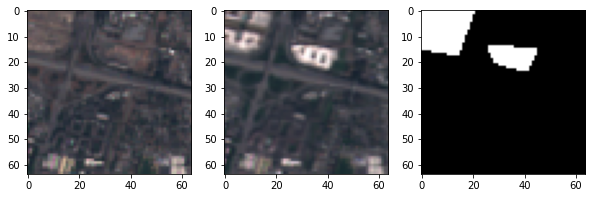

In [ ]:
train_cities = [name for name in os.listdir(train_dir) if os.path.isdir(train_dir+"/"+name)]
test_cities = [name for name in os.listdir(test_dir) if os.path.isdir(test_dir+"/"+name)]
print("train cities:", len(train_cities), "test cities:", len(test_cities))

if LOADING_METHOD == 'channels_from_tifs':
    train_triplets = dataset_from_folder(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change, 
                                     mode = mode, NORMALISE_IMGS = NORMALISE_IMGS)
    test_triplets = dataset_from_folder(test_cities,test_dir,
                                    mode = mode, NORMALISE_IMGS = NORMALISE_IMGS) # without overlap! and without filterings!

elif LOADING_METHOD == 'rgb_from_pngs':
    train_triplets = dataset_from_folder_from_png(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change)
    test_triplets = dataset_from_folder_from_png(test_cities,test_dir) # without overlap! and without filterings!

print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)

# previous:
#Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
#Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)

show_rand_tripplet(train_triplets)

#1c data augmentations

In [ ]:
# from my code at https://github.com/previtus/ChangeDetectionProject/blob/ad2bd4adb2df7a2125b0737af385572d2d743e75/ActiveLearning/TrainTestHandler.py#L42

if train_augmentations:
    print("Before Augmentation:")
    print("Images 1", train_triplets[0].shape, "Images 1", train_triplets[1].shape, "Labels", train_triplets[2].shape)

    train_L, train_R, train_V = train_triplets


    from albumentations.core.transforms_interface import DualTransform
    class RandomRotate90x1(DualTransform):
                def apply(self, img, factor=0, **params):
                    return np.ascontiguousarray(np.rot90(img, factor))

                def get_params(self):
                    return {'factor': 1}

    class RandomRotate90x2(DualTransform):
                def apply(self, img, factor=0, **params):
                    return np.ascontiguousarray(np.rot90(img, factor))

                def get_params(self):
                    return {'factor': 2}

    class RandomRotate90x3(DualTransform):
                def apply(self, img, factor=0, **params):
                    return np.ascontiguousarray(np.rot90(img, factor))

                def get_params(self):
                    return {'factor': 3}

    from albumentations import (HorizontalFlip,
                                        VerticalFlip,
                                        Compose)
    from random import randint


    augmentations = []
    augmentations.append( RandomRotate90x1(p=1) ) # 90, 180 or 270 <- we need the same for the same of l=r=y
    augmentations.append( RandomRotate90x2(p=1) ) # 90, 180 or 270 <- we need the same for the same of l=r=y
    augmentations.append( RandomRotate90x3(p=1) ) # 90, 180 or 270 <- we need the same for the same of l=r=y
    augmentations.append( HorizontalFlip(p=1) )         # H reflection
    augmentations.append( VerticalFlip(p=1) )           # V reflection

    augmentations.append( Compose([VerticalFlip(p=1), RandomRotate90x1(p=1)]) ) # V reflection and then rotation
    augmentations.append( Compose([HorizontalFlip(p=1), RandomRotate90x1(p=1)]) ) # H reflection and then rotation

    aug_lefts = []
    aug_rights = []
    aug_ys = []

    num_in_train = len(train_L)
    for i in range(num_in_train):
        #print(i)

        image_l = train_L[i]
        image_r = train_R[i]
        mask = train_V[i]

        if True:
            # choose a random augmentation ... (we don't have mem for all of them!, solve by batches or smth ...)
            aug_i = randint(0, len(augmentations)-1)
            aug = augmentations[aug_i]
            #for aug in augmentations:

            augmented1 = aug(image=image_l, mask=mask)
            augmented2 = aug(image=image_r, mask=mask)
            aug_l = augmented1['image']
            aug_y = augmented1['mask']
            aug_lefts.append(np.asarray(aug_l))
            aug_ys.append(np.asarray(aug_y))
            aug_r = augmented2['image']
            aug_rights.append(np.asarray(aug_r))
            del aug_l
            del aug_r
            del aug_y
            del augmented1
            del augmented2

    aug_lefts = np.asarray(aug_lefts)
    aug_rights = np.asarray(aug_rights)
    aug_ys = np.asarray(aug_ys)

    print("aug_lefts.shape", aug_lefts.shape)
    print("aug_rights.shape", aug_rights.shape)
    print("aug_ys.shape", aug_ys.shape)

    # Adding them to the training set
    train_L = np.append(train_L, aug_lefts, axis=0)
    train_R = np.append(train_R, aug_rights, axis=0)
    train_V = np.append(train_V, aug_ys, axis=0)

    train_triplets = train_L, train_R, train_V

    print("After Augmentation:")
    print("Images 1", train_triplets[0].shape, "Images 1", train_triplets[1].shape, "Labels", train_triplets[2].shape)

Before Augmentation:
Images 1 (1044, 64, 64, 3) Images 1 (1044, 64, 64, 3) Labels (1044, 64, 64, 1)
aug_lefts.shape (1044, 64, 64, 3)
aug_rights.shape (1044, 64, 64, 3)
aug_ys.shape (1044, 64, 64, 1)
After Augmentation:
Images 1 (2088, 64, 64, 3) Images 1 (2088, 64, 64, 3) Labels (2088, 64, 64, 1)


# 2b siamese U-Net (older code reload?)

In [ ]:
import segmentation_models as sm
from tensorflow import keras
from keras.utils.layer_utils import count_params

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [ ]:
# Siamese U-Net like from https://github.com/previtus/ChangeDetectionProject/blob/master/Model2_builder.py#L37

# [ Siamese Segmentation models ]
#
# Altered code from:
# https://github.com/qubvel/segmentation_models
# more specifically combined from files:
# - https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/unet/builder.py
# - https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/unet/blocks.py
# under commit https://github.com/qubvel/segmentation_models/commit/9c68d81d66e4fb856770a87b450a43bb2ae6ddba

from keras.layers import Conv2D
from keras.layers import Activation
from keras.models import Model

from segmentation_models.utils import freeze_model
from segmentation_models.utils import legacy_support
from segmentation_models.backbones import get_backbone, get_feature_layers

from segmentation_models.unet.blocks import Transpose2D_block
from segmentation_models.utils import get_layer_number, to_tuple

from keras.layers import Concatenate
from segmentation_models.unet.blocks import UpSampling2D, handle_block_names, ConvRelu

import keras
from keras.layers import Input
from keras.models import load_model

old_args_map = {
    'freeze_encoder': 'encoder_freeze',
    'skip_connections': 'encoder_features',
    'upsample_rates': None,  # removed
    'input_tensor': None,  # removed
}


@legacy_support(old_args_map)
def SiameseUnet(backbone_name='vgg16',
         input_shape=(None, None, 3),
         classes=1,
         activation='sigmoid',
         encoder_weights='imagenet',
         encoder_freeze=False,
         encoder_features='default',
         decoder_block_type='upsampling',
         decoder_filters=(256, 128, 64, 32, 16),
         decoder_use_batchnorm=True,
         **kwargs):
    """ Unet_ is a fully convolution neural network for image semantic segmentation

        Args:
            backbone_name: name of classification model (without last dense layers) used as feature
                extractor to build segmentation model.
            input_shape: shape of input data/image ``(H, W, C)``, in general
                case you do not need to set ``H`` and ``W`` shapes, just pass ``(None, None, C)`` to make your model be
                able to process images af any size, but ``H`` and ``W`` of input images should be divisible by factor ``32``.
            classes: a number of classes for output (output shape - ``(h, w, classes)``).
            activation: name of one of ``keras.activations`` for last model layer
                (e.g. ``sigmoid``, ``softmax``, ``linear``).
            encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
            encoder_freeze: if ``True`` set all layers of encoder (backbone model) as non-trainable.
            encoder_features: a list of layer numbers or names starting from top of the model.
                Each of these layers will be concatenated with corresponding decoder block. If ``default`` is used
                layer names are taken from ``DEFAULT_SKIP_CONNECTIONS``.
            decoder_block_type: one of blocks with following layers structure:

                - `upsampling`:  ``Upsampling2D`` -> ``Conv2D`` -> ``Conv2D``
                - `transpose`:   ``Transpose2D`` -> ``Conv2D``

            decoder_filters: list of numbers of ``Conv2D`` layer filters in decoder blocks
            decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
                is used.

        Returns:
            ``keras.models.Model``: **Unet**

        .. _Unet:
            https://arxiv.org/pdf/1505.04597

    """

    load_weights_from = None
    if encoder_weights is not "imagenet" and encoder_weights is not None:
        load_weights_from = encoder_weights
        encoder_weights = None


    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=None,
                            weights=encoder_weights,
                            include_top=False)

    if load_weights_from is not None:
        model_to_load_weights_from = load_model(load_weights_from)

        # now let's assume that this loaded model had its own "top" upsampling section trained on another task
        # let's transplant what we can, that is the backbone encoder

        output = model_to_load_weights_from.layers[len(backbone.layers)-1].output  # remove activation and last conv layer
        transplant = keras.models.Model(model_to_load_weights_from.input, output)
        #transplant.summary()

        transplant.save("transplant.h5") # hacky way
        backbone.load_weights("transplant.h5")

        # Check if the weights have been loaded
        """
        inspect_i = 0
        import numpy as np
        w1 = np.asarray(transplant.get_weights()[inspect_i])
        print(w1)
        w2 = np.asarray(backbone.get_weights()[inspect_i])
        print(w2)
        """
        print("Loaded weights into ",backbone_name,"from",load_weights_from)

    if encoder_features == 'default':
        encoder_features = get_feature_layers(backbone_name, n=4)

    model = build_siamese_unet(backbone,
                       classes,
                       encoder_features,
                       decoder_filters=decoder_filters,
                       block_type=decoder_block_type,
                       activation=activation,
                       n_upsample_blocks=len(decoder_filters),
                       upsample_rates=(2, 2, 2, 2, 2),
                       use_batchnorm=decoder_use_batchnorm,
                       input_shape=input_shape)

    # lock encoder weights for fine-tuning
    if encoder_freeze:
        freeze_model(backbone)

    model.name = 'u-{}'.format(backbone_name)

    return model



def Siamese_Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     use_batchnorm=False, skip_a=None, skip_b=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip_a is not None and skip_b is not None:
            x = Concatenate()([x, skip_a, skip_b]) # siamese concatenation

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '1', bn_name=bn_name + '1', relu_name=relu_name + '1')(x)

        x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                     conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)

        return x
    return layer


def build_siamese_unet(backbone, classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5, # less?
               block_type='upsampling',
               activation='sigmoid',
               use_batchnorm=True,
               input_shape=(None, None, 3)):

    verbose = False
    if verbose:
        print("Entered build_unet with arguments:")
        print("backbone",backbone)
        #print("---\n")
        #backbone.summary()
        #print("---\n")


        print("classes",classes)
        print("skip_connection_layers",skip_connection_layers)
        print("decoder_filters",decoder_filters)
        print("upsample_rates",upsample_rates)
        print("n_upsample_blocks",n_upsample_blocks)
        print("block_type",block_type)
        print("activation",activation)
        print("use_batchnorm",use_batchnorm)

    input = backbone.input
    x = backbone.output

    # Prepare for multiple heads in siamese nn:

    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])
    if verbose:
        print("skip_connection_idx", skip_connection_idx)

    skip_connections = []
    for idx in skip_connection_idx:
        skip_connection = backbone.layers[idx].output
        skip_connections.append(skip_connection)

    if verbose:
        print("skip_connections layers", len(skip_connections), skip_connections)
    #4 layers
    # 'stage4_unit1_relu1/Relu:0' shape=(?, 16, 16, 256)
    # 'stage3_unit1_relu1/Relu:0' shape=(?, 32, 32, 128)
    # 'stage2_unit1_relu1/Relu:0' shape=(?, 64, 64, 64)
    # 'relu0/Relu:0'              shape=(?, 128, 128, 64)

    siamese_backbone_model_encode = Model(inputs=[input], outputs=[x]+skip_connections)

    if verbose:
        print("siamese_model_encode.input", siamese_backbone_model_encode.input)
        print("siamese_model_encode.output", siamese_backbone_model_encode.output) # x and the (now 4) skip connections

    # Then merging
    input_a = Input(shape=(input_shape[0], input_shape[1], input_shape[2]))
    input_b = Input(shape=(input_shape[0], input_shape[1], input_shape[2]))

    branch_a_outputs = siamese_backbone_model_encode([input_a])
    branch_b_outputs = siamese_backbone_model_encode([input_b])

    branch_a = branch_a_outputs[0]
    branch_b = branch_b_outputs[0]

    x = Concatenate(name="concatHighLvlFeat")([branch_a, branch_b]) # both inputs, in theory 8x8x512 + 8x8x512 -> 8x8x1024

    skip_connection_outputs_a = branch_a_outputs[1:]
    skip_connection_outputs_b = branch_b_outputs[1:]

    if block_type == 'transpose':
        up_block = Transpose2D_block
        assert False # NOT IMPLEMENTED
    else:
        up_block = Siamese_Upsample2D_block

    for i in range(n_upsample_blocks):
        skip_connection_a = None
        skip_connection_b = None
        if i < len(skip_connection_idx): # also till len(skip_connection_outputs_a)
            skip_connection_a = skip_connection_outputs_a[i]
            skip_connection_b = skip_connection_outputs_b[i]

        upsample_rate = to_tuple(upsample_rates[i])

        x = up_block(decoder_filters[i], i, upsample_rate=upsample_rate,
                     skip_a=skip_connection_a, skip_b=skip_connection_b, use_batchnorm=use_batchnorm)(x)

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    #model = Model(input, x)
    full_model = Model(inputs=[input_a, input_b], outputs=x)

    return full_model


In [ ]:
# There is support for all of these (with weights from ImageNet included) ... qubvel/segmentation_models is awesome!
# VGG           'vgg16' 'vgg19'
# ResNet	    'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'
# SE-ResNet	    'seresnet18' 'seresnet34' 'seresnet50' 'seresnet101' 'seresnet152'
# ResNeXt	    'resnext50' 'resnet101'
# SE-ResNeXt	'seresnext50' 'seresnet101'
# SENet154	    'senet154'
# DenseNet	    'densenet121' 'densenet169' 'densenet201'
# Inception	    'inceptionv3' 'inceptionresnetv2'
# MobileNet	    'mobilenet' 'mobilenetv2'
# Performance comparison for classification: https://github.com/qubvel/classification_models

# Ps: there is posibility to change the code of additional models in similar manner to get FPN, Linknet and PSPNet
# Ps2: some of these Siamese NN models end up with large amount of parameters ...
#      if we don't have much data, we should perhaps freeze some of the layers of the encoder... "encoder_freeze=False"

# Ps3: keras saves models into $ cd /home/<username>/.keras/models/

In [ ]:
channels = 3
if mode == 'highres':
    channels = 10
elif mode == 'all':
    channels = 13

input_shape=(tile_size, tile_size, channels)
input_shape=(None, None, channels)
model = SiameseUnet(BACKBONE, encoder_weights=custom_weights_file, classes=1, activation='sigmoid', input_shape=input_shape,
#                    decoder_filters=(256, 128, 64, 32, 16),
#                    encoder_freeze=True
)

print("Model loaded:")
print("model.input", model.input)
print("model.output", model.output)
print("Trainable params:", count_params(model.trainable_weights))













44924928/44920640 [==============================] - 1s 0us/step

Model loaded:
model.input [<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>]
model.output Tensor("sigmoid/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)
Trainable params: 16302868


In [ ]:
model.summary()
#model.layers[2].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, None, None,  11186889    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatHighLvlFeat (Concatenate) (None, None, None, 1 0           model_2[1][0]                    
          

In [ ]:
# Note:
# referential UNet with concat and RGB at source with 96x96 patches has: 1 545 986 trainable params
# this one we made here has for RGB at source with 64x64 patches:       26 411 028 ~ most from the ResNet34 model!

#### 

""" SiamUnet_conc:
SiamUnet_conc(
  (conv11): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do11): Dropout2d(p=0.2, inplace=False)
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do12): Dropout2d(p=0.2, inplace=False)
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do21): Dropout2d(p=0.2, inplace=False)
  (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do22): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do31): Dropout2d(p=0.2, inplace=False)
  (conv32): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do32): Dropout2d(p=0.2, inplace=False)
  (conv33): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn33): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do33): Dropout2d(p=0.2, inplace=False)
  (conv41): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn41): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do41): Dropout2d(p=0.2, inplace=False)
  (conv42): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn42): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do42): Dropout2d(p=0.2, inplace=False)
  (conv43): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn43): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do43): Dropout2d(p=0.2, inplace=False)
  (upconv4): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv43d): ConvTranspose2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn43d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do43d): Dropout2d(p=0.2, inplace=False)
  (conv42d): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn42d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do42d): Dropout2d(p=0.2, inplace=False)
  (conv41d): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn41d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do41d): Dropout2d(p=0.2, inplace=False)
  (upconv3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv33d): ConvTranspose2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn33d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do33d): Dropout2d(p=0.2, inplace=False)
  (conv32d): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do32d): Dropout2d(p=0.2, inplace=False)
  (conv31d): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do31d): Dropout2d(p=0.2, inplace=False)
  (upconv2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv22d): ConvTranspose2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do22d): Dropout2d(p=0.2, inplace=False)
  (conv21d): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do21d): Dropout2d(p=0.2, inplace=False)
  (upconv1): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv12d): ConvTranspose2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do12d): Dropout2d(p=0.2, inplace=False)
  (conv11d): ConvTranspose2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sm): LogSoftmax(dim=1)
)
"""

pass

In [ ]:
preprocess_input = sm.backbones.get_preprocessing(BACKBONE)

In [ ]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# Model shapes:
# model.input [<tf.Tensor 'input_3:0' shape=(?, 64, 64, 3) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 64, 64, 3) dtype=float32>]
# model.output Tensor("softmax_1/truediv:0", shape=(?, 64, 64, 3), dtype=float32)


def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = [preprocess_input(train_im1), preprocess_input(train_im2)]
    x = np.asarray(x)
    y = train_labels
    
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (2088, 64, 64, 3) (2088, 64, 64, 3) (2088, 64, 64, 1)
out (2, 2088, 64, 64, 3) (2088, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (2, 663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [ ]:
import segmentation_models as sm
from keras.optimizers import Adam

#bce_jaccard_loss = binary_crossentropy + jaccard_loss
model.compile(optimizer=Adam(lr=0.001), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,'accuracy'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator

history = model.fit(
   x=[x_train[0], x_train[1]],
   y=y_train,
   batch_size=16, # 16 originally
   epochs=epochs,
   validation_data=([x_val[0], x_val[1]], y_val),
   class_weight=weights
)



Train on 2088 samples, validate on 663 samples
Epoch 1/30
2088/2088 [==============================] - 41s 20ms/step - loss: 1.1736 - iou_score: 0.1416 - acc: 0.8889 - val_loss: 1.1767 - val_iou_score: 0.0806 - val_acc: 0.9334
Epoch 2/30
2088/2088 [==============================] - 27s 13ms/step - loss: 0.9126 - iou_score: 0.3185 - acc: 0.9122 - val_loss: 1.2523 - val_iou_score: 0.0894 - val_acc: 0.9152
Epoch 3/30
2088/2088 [==============================] - 27s 13ms/step - loss: 0.8311 - iou_score: 0.3819 - acc: 0.9220 - val_loss: 0.9901 - val_iou_score: 0.1671 - val_acc: 0.9515
Epoch 4/30
2088/2088 [==============================] - 27s 13ms/step - loss: 0.7633 - iou_score: 0.4291 - acc: 0.9308 - val_loss: 1.0380 - val_iou_score: 0.1674 - val_acc: 0.9304
Epoch 5/30
2088/2088 [==============================] - 27s 13ms/step - loss: 0.7573 - iou_score: 0.4360 - acc: 0.9319 - val_loss: 1.1592 - val_iou_score: 0.1492 - val_acc: 0.9090
Epoch 6/30
2088/2088 [=============================

In [ ]:
if second_round_of_slower_lr_training:
    # train a bit more with a slower lr
    # might need more of these tho~

    slower_lr = 0.001 / 10
    model.compile(optimizer=Adam(lr=slower_lr), loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,'accuracy'])
    
    weights = [0.4595, 1.9540]
    history_slower = model.fit(
      x=[x_train[0], x_train[1]],
      y=y_train,
      batch_size=16, # 16 originally
      epochs=slower_epochs,
      validation_data=([x_val[0], x_val[1]], y_val),
      class_weight=weights 
    )
    print("history_slower.history = ", history_slower.history)

Train on 2088 samples, validate on 663 samples
Epoch 1/30
2088/2088 [==============================] - 36s 17ms/step - loss: 0.2314 - iou_score: 0.8200 - acc: 0.9844 - val_loss: 1.1144 - val_iou_score: 0.1798 - val_acc: 0.9544
Epoch 2/30
2088/2088 [==============================] - 26s 13ms/step - loss: 0.2200 - iou_score: 0.8285 - acc: 0.9853 - val_loss: 1.1306 - val_iou_score: 0.1774 - val_acc: 0.9542
Epoch 3/30
2088/2088 [==============================] - 26s 13ms/step - loss: 0.2129 - iou_score: 0.8342 - acc: 0.9858 - val_loss: 1.1015 - val_iou_score: 0.1877 - val_acc: 0.9535
Epoch 4/30
2088/2088 [==============================] - 26s 13ms/step - loss: 0.2054 - iou_score: 0.8397 - acc: 0.9864 - val_loss: 1.1050 - val_iou_score: 0.1883 - val_acc: 0.9532
Epoch 5/30
2088/2088 [==============================] - 26s 13ms/step - loss: 0.2011 - iou_score: 0.8431 - acc: 0.9867 - val_loss: 1.0970 - val_iou_score: 0.1994 - val_acc: 0.9512
Epoch 6/30
2088/2088 [==============================]

In [ ]:
h = history.history
print(history.history.keys())

# todo: merge the two histories...

dict_keys(['val_loss', 'val_iou_score', 'val_acc', 'loss', 'iou_score', 'acc'])


In [ ]:
print("history.history = ", history.history)

history.history =  {'val_loss': [1.17674162646764, 1.2522537188652234, 0.9900600205359595, 1.0380176001904058, 1.1591634264898516, 0.9733369238955583, 0.9865427031596142, 1.0286977999530407, 1.077027089994957, 1.0548539618381367, 0.9919471909737335, 1.0204819611654383, 1.0829738538549316, 1.0498450597127278, 1.068117127159602, 1.089600360950913, 1.0913733720419814, 1.0510313237594444, 1.0586905091056997, 1.0794216662330685, 1.056473329236245, 1.0650991181622442, 1.081816307200206, 1.0679850337372288, 1.077233886646829, 1.2884292386775642, 1.0742845150500222, 1.087304498994692, 1.091207613232988, 1.176964607713449], 'val_iou_score': [0.08063476288102589, 0.08935834874394968, 0.1671127605200696, 0.16739848297927598, 0.1492422919080917, 0.1964491238678594, 0.1930261610896566, 0.1852072640965407, 0.17391369433796663, 0.1630816772353758, 0.18312691369639245, 0.18066465730859116, 0.1803610889932436, 0.18697176481203082, 0.17366298659435087, 0.18151250494266435, 0.1693633721252112, 0.19699973

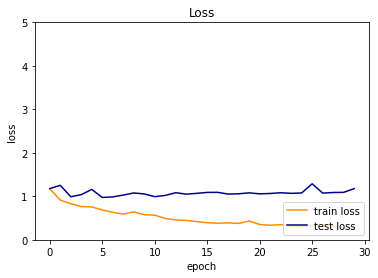

In [ ]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

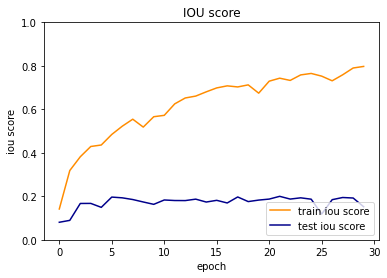

In [ ]:
plt.figure()
plt.plot(h['iou_score'], color='darkorange', label='train iou score')
plt.plot(h['val_iou_score'], color='darkblue', label='test iou score')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('IOU score')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_iou.png")
#plt.close()

In [ ]:
def predict_with_model_rand(triplets, name=""):
    im1,im2,lab = random_from_triplet(triplets)
    
    # Now predict with the model:
    x = [preprocess_input(im1), preprocess_input(im2)]

    x = np.asarray(x)
    x = x.astype(np.float32)

    y = lab.astype(np.float32)


    input_arr = [np.array([x[0]]),
                            np.array([x[1]])]
    
    y_pred = model.predict( input_arr
                          )
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred, save_name=name)

    # show thresholded instead?
    #y_pred = (y_pred > 0.5)
    #show_four(im1,im2,lab,y_pred)


#91
Prediction visualization
#445
Prediction visualization
#226
Prediction visualization
#357
Prediction visualization
#620
Prediction visualization
#628
Prediction visualization
#547
Prediction visualization
#20
Prediction visualization
#634
Prediction visualization
#488
Prediction visualization
#337
Prediction visualization
#263
Prediction visualization
#221
Prediction visualization
#383
Prediction visualization
#134
Prediction visualization


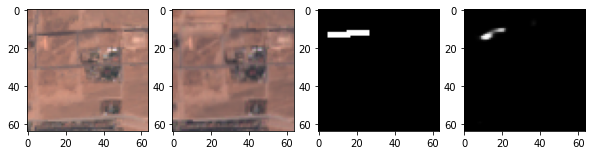

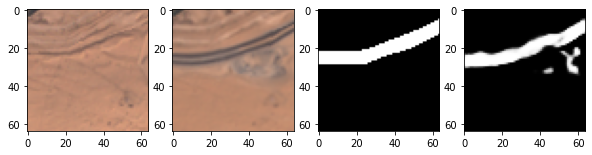

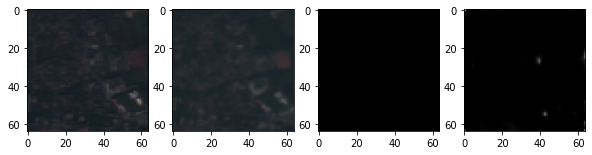

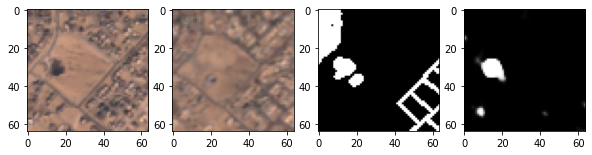

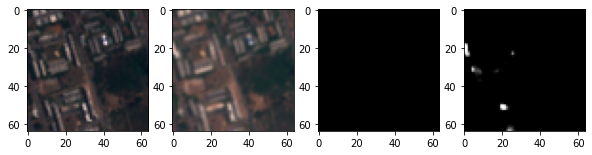

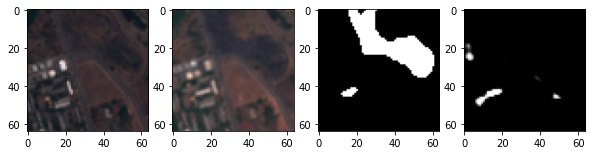

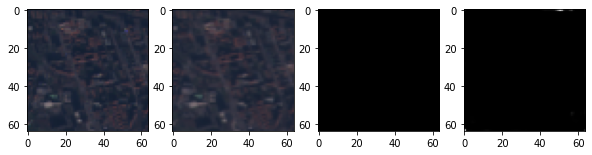

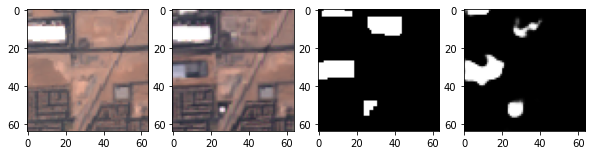

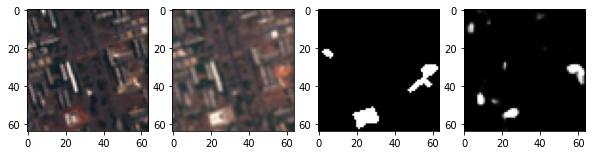

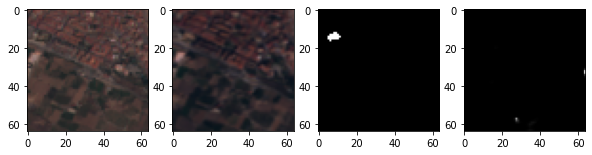

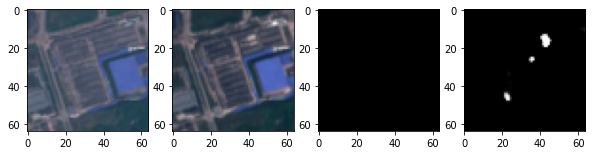

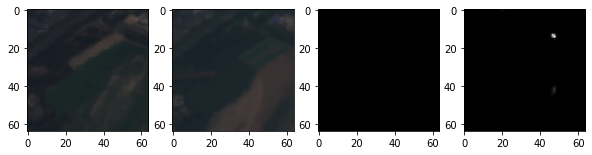

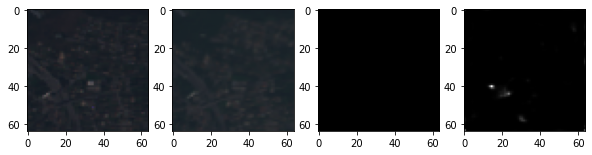

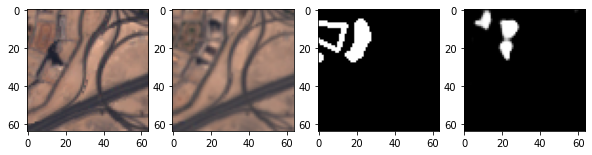

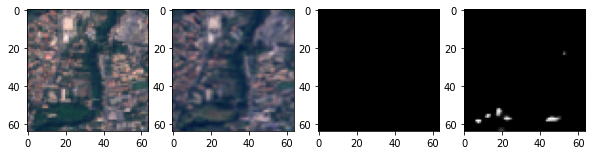

In [ ]:
for idx in range(15):
    predict_with_model_rand(test_triplets, name="rand_prediction_idx_"+str(idx).zfill(3)+".pdf")

# 3a Evaluation

#438
Prediction visualization


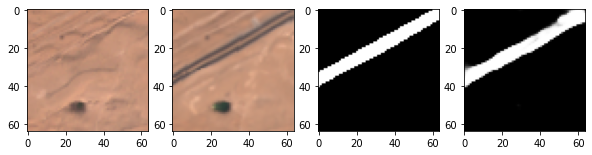

In [ ]:
predict_with_model_rand(test_triplets)
#predict_with_model_rand(train_triplets)

In [ ]:
# from my repo ~ https://github.com/previtus/ChangeDetectionProject/blob/master/Evaluator.py

def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1



def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets    
    # Now predict with the model:
    x = [preprocess_input(images1), preprocess_input(images2)]

    x = np.asarray(x)
    x = x.astype(np.float32)

    y = ground_truths.astype(np.float32)

    predictions = model.predict([ 
      x[0],
      x[1]
    ])
    return predictions, ground_truths

In [ ]:
def load_from_images(image1_path, image2_path, gt_path):
    im1 = Image.open(image1_path)
    im2 = Image.open(image2_path)
    lab = Image.open(gt_path).convert('L') # LA is with transparency

    im1 = np.array(im1) / 255 # scale
    im2 = np.array(im2) / 255 # scale
    lab = np.array(lab) / 255 # scale 0 or 1
    lab = lab.astype(np.uint8)
    lab = np.expand_dims(lab, axis=2)

    return im1, im2, lab

def predict_on_image(path_with_city, instead_of_pad_crop_to_multiple_of_tilesize = True):
    image1_path = path_with_city + "/pair/" + "img1.png"
    image2_path = path_with_city + "/pair/" + "img2.png"
    gt_path = path_with_city + "/cm/cm.png"
    
    image1,image2,gt = load_from_images(image1_path, image2_path, gt_path)

    ### Pad

    h,w,ch = image1.shape
    #print("in as",image1.shape) # (2, 545, 558, 3)

    #image1 = adjust_shape(image1, (1024, 1024, 3))
    #image2 = adjust_shape(image2, (1024, 1024, 3))

    if not instead_of_pad_crop_to_multiple_of_tilesize:
        mult_h = 128
        mult_w = 128
        while mult_h < h:
            mult_h *= 2
        while mult_w < h:
            mult_w *= 2
        
        image1 = np.pad(image1,((0,mult_h-h),(0,mult_w-w),(0,0)),'edge')
        image2 = np.pad(image2,((0,mult_h-h),(0,mult_w-w),(0,0)),'edge')
        #print(image1.shape)

    else:
        # crop as multiple of tile size
        w_max = 0
        h_max = 0

        overlap_test=0
        move_by = tile_size - overlap_test

        h, w, ch = image1.shape
        h_current = 0
        w_current = 0
        while h_current + tile_size < h:
            while w_current + tile_size < w:
                row_start = h_current
                row_end = h_current + tile_size
                col_start = w_current
                col_end = w_current + tile_size
                w_current += move_by

                w_max = max(w_max, col_end)
                h_max = max(h_max, row_end)
            h_current += move_by
            w_current = 0

        image1 = image1[:h_max, :w_max, :]
        image2 = image2[:h_max, :w_max, :]
        gt = gt[:h_max, :w_max, :]

        print("instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now: ",image1.shape)


    # Now predict with the model:
    x = [preprocess_input(image1), preprocess_input(image2)]

    x = np.asarray(x)
    x = x.astype(np.float32)
    y = gt.astype(np.float32)

    #print("padded as",x.shape) # (2, 545, 558, 3)

    input_arr = [np.array([x[0]]),
                            np.array([x[1]])]
  
    prediction = model.predict( input_arr ) 
    prediction = prediction[0]

    ### Crop
    if not instead_of_pad_crop_to_multiple_of_tilesize:

      image1 = image1[:h,:w,:]
      image2 = image2[:h,:w,:]
      gt = gt[:h,:w,:]
      prediction = prediction[:h,:w,:]
      #print("cropped as",image1.shape) # (2, 545, 558, 3)

    return image1,image2, gt, prediction

def predict_all_cities(cities_folder, instead_of_pad_crop_to_multiple_of_tilesize):
    all_gts=np.array([])
    all_predictions=np.array([])
    
    #all_gts = []
    #all_predictions = []

    for city in cities_folder:
        print("predicting for", city)
        path_with_city = img_dir + "/" + city + "/"
        im1, im2, gt, prediction = predict_on_image(path_with_city, instead_of_pad_crop_to_multiple_of_tilesize)

        #show_four(im1, im2, gt, prediction)

        all_gts=np.append(all_gts,gt)
        all_predictions=np.append(all_predictions,prediction)

        #all_gts.append(gt)
        #all_predictions.append(prediction)

    all_gts = np.asarray(all_gts)
    all_predictions = np.asarray(all_predictions)

    #print("flatten by 1 I think > all_gts.shape", all_gts.shape)

    return all_predictions, all_gts


### version a - eval loaded tiles

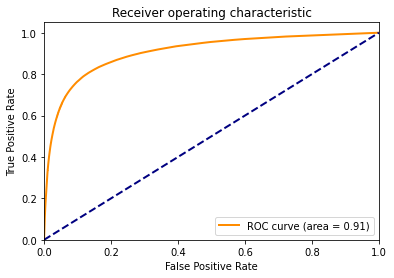

Finished with AUC (test set) = 0.9065986094789613
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.56      0.47      0.51    146025

    accuracy                           0.95   2715648
   macro avg       0.77      0.72      0.74   2715648
weighted avg       0.95      0.95      0.95   2715648

[[2516179   53444]
 [  77347   68678]]
saving to... test.txt
Recall 0.470316726587913 Prec 0.5623720541753329 Acc 0.9518380143523756 F1 0.512241419818234


In [ ]:
predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

#train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
#auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
#print("Finished with AUC (train set) =",auc)
#recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
#print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)


### version b - eval on loaded full images (doesn't match!)

predicting for lasvegas
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (768, 704, 3)
predicting for montpellier
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (384, 448, 3)
predicting for saclay_w
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (576, 640, 3)
predicting for chongqing
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (704, 512, 3)
predicting for dubai
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (768, 576, 3)
predicting for valencia
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (448, 448, 3)
predicting for milano
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (512, 512, 3)
predicting for rio
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (320, 384, 3)
predicting for brasilia
instead_of_pad_crop_to_multiple_of_tilesize, so the image1 shape is now:  (384, 448, 3

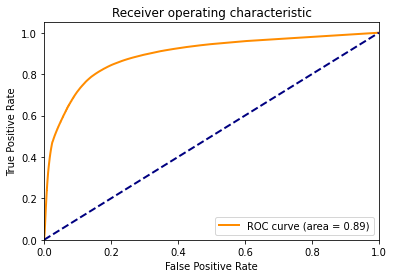

Finished with AUC (test set) = 0.8910836673872773
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.52      0.47      0.49    146025

    accuracy                           0.95   2715648
   macro avg       0.74      0.72      0.73   2715648
weighted avg       0.95      0.95      0.95   2715648

[[2505684   63939]
 [  77029   68996]]
saving to... test.txt
Recall 0.4724944358842664 Prec 0.5190205739647196 Acc 0.9480904741704375 F1 0.49466590192142235


In [ ]:
### Eval from full image predictions:

# is it possible that its not fully working the same??

instead_of_pad_crop_to_multiple_of_tilesize = True # trying to replicate the full test
# \ maybe better to predict all the tiles and then merge until there's a non existing area (crop that out) in right bottom

predictions, ground_truths = predict_all_cities(test_cities, instead_of_pad_crop_to_multiple_of_tilesize=instead_of_pad_crop_to_multiple_of_tilesize)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)


### version e - pad by mirroring to fill in the last "lost" area, because that one technically contains "change" pixels

 ... the overall look might be a bit different, but it's not too much different from the regular weird effect at the tile edge anyway ...

 ... kinda cleaner perhaps ?

Normal total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)
Total test with Mirrored edge (reflect)... im1: (831, 64, 64, 3) im2: (831, 64, 64, 3) lab: (831, 64, 64, 1)


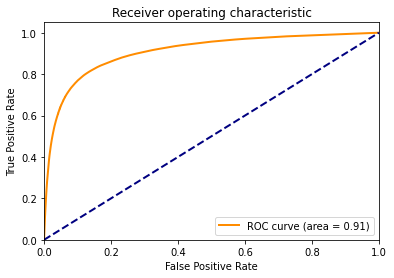

Finished with AUC (test set) = 0.9075427179459724
              precision    recall  f1-score   support

   no change       0.97      0.98      0.98   3234851
      change       0.53      0.48      0.50    168925

    accuracy                           0.95   3403776
   macro avg       0.75      0.73      0.74   3403776
weighted avg       0.95      0.95      0.95   3403776

[[3161854   72997]
 [  88021   80904]]
saving to... test.txt
Recall 0.47893443836021904 Prec 0.525688592016946 Acc 0.9526943018577015 F1 0.5012235693531499


In [ ]:
def tile_image_from_png_MIRROR(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape
    
    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    
    #print(h_num, heights)
    #print(w_num, widths)

    h_new = tile_size * math.ceil(h / tile_size)
    w_new = tile_size * math.ceil(w / tile_size)

    #print("before pad", im1.shape)
    im1 = np.pad(im1,((0,h_new-h),(0,w_new-w),(0,0)),mode='reflect') #, 'edge')
    im2 = np.pad(im2,((0,h_new-h),(0,w_new-w),(0,0)),mode='reflect') #,'edge')
    label = np.pad(label,((0,h_new-h),(0,w_new-w),(0,0)),mode='reflect') #,'edge')
    #print("after pad", im1.shape)    

    h_current = 0
    w_current = 0
    while h_current + tile_size <= h_new: #h:
        while w_current + tile_size <= w_new: # w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]
            
            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder_from_png_MIRROR(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images 
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        #print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image_from_png_MIRROR(im1, im2, lab, overlap_for_tiling, filter_on)
        #print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

if LOADING_METHOD == 'rgb_from_pngs':
    test_triplets_MIRROR = dataset_from_folder_from_png_MIRROR(test_cities,test_dir)

    print("Normal total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)
    print("Total test with Mirrored edge (reflect)... im1:",test_triplets_MIRROR[0].shape, "im2:",test_triplets_MIRROR[1].shape, "lab:",test_triplets_MIRROR[2].shape)

else:
    assert False

### Now test with these:
predictions, ground_truths = predict_with_model_all(test_triplets_MIRROR)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

# 3b Metrics comparable with other papers

In [ ]:
# code snippet from https://github.com/rcdaudt/fully_convolutional_change_detection/blob/master/fully-convolutional-change-detection.ipynb
# edited for the current outputs

L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test(triplets):
    predictions, ground_truths = predict_with_model_all(triplets)

    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    if True:
        ### predictions, ground_truths
        """
        c = (predictions.int() == ground_truths.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(ground_truths[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
        """
        tot_count += np.prod(ground_truths.shape)

        # Our net predicts <0 to 1> which makes sense to threshold at 0.5
        # The other code was likely predicting at - 0 to non0
        #pr = (predictions.int() > 0)
        #gt = (ground_truths.int() > 0)
        pr = (predictions > 0.5)
        gt = (ground_truths > 0.5)

        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    #net_loss = tot_loss/tot_count        
    #net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    #for i in range(n):
    #    class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
    #    class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {    #'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k}

results = test(test_triplets)
pprint(results)

{'class_accuracy': [0.0, 0.0],
 'dice': 0.512241419818234,
 'kappa': 0.4871214425397649,
 'net_accuracy': 95.18380143523756,
 'precision': 0.5623720541753329,
 'recall': 0.470316726587913}


**Compare scores:**


Model | Prec | Recall | Global | F1
---   | ---  | ---    | ---    | ---
**paper: FC-Siam-conc (rgb)** (96x96, smaller 1.5M) | 42.89  | 47.77    | 94.07    | 45.20
our: FC-Siam-conc (rgb) (64x64, big 22M)        | ---  | ---    | ---    | ---
---   | ---  | ---    | ---    | ---
**paper: FC-Siam-conc (13 ch.)** (96x96, smaller 1.5M) | 42.39  | 65.15    | 93.68    | 51.36




In [ ]:
# best so far:
"""
Version '1d' ( + back to png loaded data (assuming normalised, preprocessed), tweaks)

Finished with AUC (test set) = 0.9170912931972113
              precision    recall  f1-score   support

   no change       0.97      0.97      0.97   2569623
      change       0.53      0.54      0.53    146025

(difference with 1a = allowed augmentation +1x the train data, trained for further 30 epochs with /10 lr)

Version '1c' ( + more channels and from scratch )

 <? maybe the data loaded from tifs is highly non-normalised >

Version '1b' ( + data augmentation + larger train) <<< Took very long!

 <? didn't seem to help TOO MUCH ... >

Version '1a' (SiamUnet with ResNet34 encoder)

Finished with AUC (test set) = 0.883090876927767
              precision    recall  f1-score   support

   no change       0.97      0.98      0.97   2569623
      change       0.53      0.41      0.46    146025

    accuracy                           0.95   2715648    
"""

pass

**=====**

In [ ]:
assert False

AssertionError: ignored

In [ ]:
!zip predictions_examples.zip *.pdf